## M04_1_addressee_classification_NH
A script that attempts the classification of the nominal 'addressee' variable for using a range of algorithms implemented using scikit learn and ~~the SMaPP text classifier~~ pipeline. Before this, I generated addressee classifications for all tweets using the tweet-text-filtering method (see script M03.R). So, beyond generating the classifications in this script, I will also compare them to the ones obtained through filtering. 

NL, 21/07/20  
NL, 05/10/20 -- updating this script, as there were discrepancies with the input and the output data and that has to be fixed


See also: M04_2, M04_3 --> both are also jupyter notebooks that execute the same code as here

In [14]:
import matplotlib.pyplot as plt
import random
import joblib

import json
import sklearn

import numpy as np
import pandas as pd

from pprint import pprint

In [15]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
set(stopwords.words('english'))

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

### DATA IN

In [16]:
LABELLED_TWEETS = "/Users/nikloynes/Desktop/SENTIMENT/data/labelled_tweets/fmtd_with_metadata/"
UNLABELLED_TWEETS = "/Users/nikloynes/Desktop/SENTIMENT/data/located_users_tweets/with_mention_dummies/"
DATA_OUT = "/Users/nikloynes/Desktop/SENTIMENT/data/classifications_rerun/"

In [17]:
nh_df = pd.read_csv(LABELLED_TWEETS + 'new_hampshire.csv',  dtype=str)

In [18]:
nh_unlabelled_df = pd.read_json(UNLABELLED_TWEETS + 'new_hampshire.json', dtype=str, lines=True)

In [27]:
len(nh_df)

1000

In [28]:
len(nh_unlabelled_df)

18082

In [24]:
nh_df

,id,text,bernie_score,hillary_score,addressee,timestamp,user_id,municipality,admin,county,ideology_bin,n_tweets,n_hillary,n_bernie,pop_norm,pop_quantiles
0,695344964755017728,Donald Trump and Bernie Sanders win the New Ha...,1,NaN,Bernie Sanders,2016-02-04 15:35:33,81126182,Durham,New Hampshire,United States,moderate,1,0,1,0.84239714193742,4
1,696840745370529792,Hillary Clinton mulls a campaign staff shake-u...,NaN,-1,Hillary Clinton,2016-02-08 18:39:15,29599480,Concord,New Hampshire,United States,conservative,28,21,12,3.46541467057069,4
2,694249917829750784,RT @jhutch1992: Let's be clear. This campaign ...,3,NaN,Bernie Sanders,2016-02-01 15:04:13,400255860,Concord,New Hampshire,United States,moderate,1,0,1,3.46541467057069,4
3,696497445996359680,RT @MeninistTweet: Rt for puppy monkey baby\n\...,NaN,-2,Hillary Clinton,2016-02-07 19:55:06,3046904705,Newmarket,New Hampshire,United States,liberal,1,1,0,0.309323543610196,4
4,696823971052920832,My predictions for #NH #FITN tomorrow: @Bernie...,0,NaN,Bernie Sanders,2016-02-08 17:32:35,28696353,Concord,New Hampshire,United States,liberal,1,0,1,3.46541467057069,4
5,696084254535581696,RT @billyeichner: .@BernieSanders R u in the B...,0,NaN,Bernie Sanders,2016-02-06 16:33:13,2380466915,Temple,New Hampshire,United States,NaN,1,0,1,-0.398387284053269,2
6,694603988491210752,"""Hell yeah more like Hill yeah!"" @johnbfortesc...",NaN,3,Hillary Clinton,2016-02-02 14:31:10,320343568,Hampton,New Hampshire,United States,moderate,2,1,1,0.916440335531801,4
7,696899637219708928,RT @peterdaou: The massive trolling operation ...,NaN,3,Hillary Clinton,2016-02-08 22:33:15,99775711,Concord,New Hampshire,United States,liberal,43,37,18,3.46541467057069,4
8,695459064910901248,RT @PolitiFact: Bernie Sanders says six bank c...,1,NaN,Bernie Sanders,2016-02-04 23:08:56,15013503,Concord,New Hampshire,United States,NaN,10,2,9,3.46541467057069,4
9,696400615065448448,SNL Sends Up Larry David and Bernie Sanders wi...,2,NaN,Bernie Sanders,2016-02-07 13:30:19,154274811,Manchester,New Hampshire,United States,liberal,2,0,2,9.71701612973264,4


In [26]:
from io import StringIO
col = ['id', 'addressee', 'text']
nh_df = nh_df[col]
nh_df = nh_df[pd.notnull(nh_df['text'])]
nh_df.columns = ['id', 'addressee', 'text']
nh_df['category_id'] = nh_df['addressee'].factorize()[0]
category_id_nh_df = nh_df[['addressee', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_nh_df.values)
id_to_category = dict(category_id_nh_df[['category_id', 'addressee']].values)
nh_df.head(n=100)

,id,addressee,text,category_id
0,695344964755017728,Bernie Sanders,Donald Trump and Bernie Sanders win the New Ha...,0
1,696840745370529792,Hillary Clinton,Hillary Clinton mulls a campaign staff shake-u...,1
2,694249917829750784,Bernie Sanders,RT @jhutch1992: Let's be clear. This campaign ...,0
3,696497445996359680,Hillary Clinton,RT @MeninistTweet: Rt for puppy monkey baby\n\...,1
4,696823971052920832,Bernie Sanders,My predictions for #NH #FITN tomorrow: @Bernie...,0
5,696084254535581696,Bernie Sanders,RT @billyeichner: .@BernieSanders R u in the B...,0
6,694603988491210752,Hillary Clinton,"""Hell yeah more like Hill yeah!"" @johnbfortesc...",1
7,696899637219708928,Hillary Clinton,RT @peterdaou: The massive trolling operation ...,1
8,695459064910901248,Bernie Sanders,RT @PolitiFact: Bernie Sanders says six bank c...,0
9,696400615065448448,Bernie Sanders,SNL Sends Up Larry David and Bernie Sanders wi...,0


## THE CATEGORY IDS ARE: 
**Bernie: 0  
Hillary: 1  
both: 2  
neither: 3**

In [91]:
print(nh_df.text[0])

Donald Trump and Bernie Sanders win the New Hampshire Primary, well that what New Hampshire kids say!  On Tuesday... https://t.co/rnNQzMmSlr


In [29]:
nh_df.category_id.unique()

array([0, 1, 2, 3])

2020-10-06 07:22:13,604 - matplotlib.axes._base - DEBUG - update_title_pos
2020-10-06 07:22:13,617 - matplotlib.font_manager - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
2020-10-06 07:22:13,662 - matplotlib.axes._base - DEBUG - update_title_pos
2020-10-06 07:22:13,682 - matplotlib.axes._base - DEBUG - update_title_pos
2020-10-06 07:22:13,697 - matplotlib.axes._base - DEBUG - update_title_pos


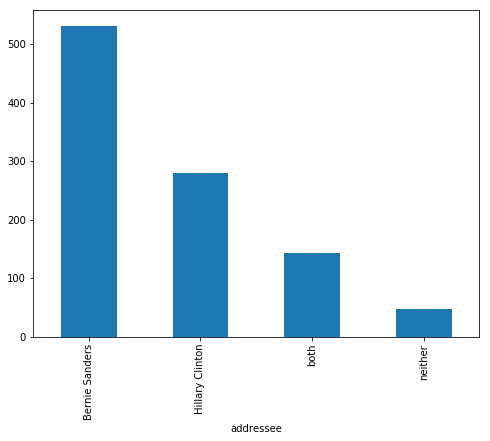

In [30]:
fig = plt.figure(figsize=(8,6))
nh_df.groupby('addressee').text.count().plot.bar(ylim=0)
plt.show()

# classes are unbalanced!!!

#### Upsampling all response categories

As shown in the bar plot above, the 4 classes (Bernie, Hillary, both, neither) are unbalanced in the training data. While there is no guarantee that this is the best thing to do in such a case, it makes sense to create an upsampled dataset in which all response categories are equally prevalent.

In [31]:
train_zero = nh_df[nh_df.category_id==0]
train_one = nh_df[nh_df.category_id==1]
train_two = nh_df[nh_df.category_id==2]
train_three = nh_df[nh_df.category_id==3]

train_one_upsampled = sklearn.utils.resample(train_one,
                               replace=True, 
                               n_samples=len(train_zero),
                               random_state=123)

train_two_upsampled = sklearn.utils.resample(train_two,
                               replace=True, 
                               n_samples=len(train_zero),
                               random_state=123)

train_three_upsampled = sklearn.utils.resample(train_three,
                                 replace=True, 
                                 n_samples=len(train_zero),
                                 random_state=123)

nh_upsampled_df = pd.concat([train_zero, train_one_upsampled, train_two_upsampled, train_three_upsampled])
nh_upsampled_df['category_id'].value_counts()

3    531
1    531
2    531
0    531
Name: category_id, dtype: int64

#### Vectorising the data to tf-idf

Sklearn can't learn the relationship between texts and labels directly -- first, the text needs to be transformed to a numerical representation. The below cell does this using the tf-idf method (term frequency, inverse document frequency). This method is likely superior to the simple 'bag of words' (term frequency) model, as it not only takes into account the frequency of a given term within a document (tweet), but also how it is relatively differenlty likely to appear in a given document. This helps the classifier decide on the correct class for a given tweet.

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, 
                        min_df=5, 
                        norm='l2', 
                        encoding='latin-1', 
                        ngram_range=(1, 2), 
                        stop_words='english')

features = tfidf.fit_transform(nh_upsampled_df.text)
labels = nh_upsampled_df.category_id
features.shape

(2124, 1935)

#### Exploratory metrics: Most correlated n-grams / training labels

In [33]:
from sklearn.feature_selection import chi2
N = 2

for addressee, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(addressee))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Bernie Sanders':
  . Most correlated unigrams:
. sanders
. bernie
  . Most correlated bigrams:
. hillary clinton
. bernie sanders
# 'Hillary Clinton':
  . Most correlated unigrams:
. clinton
. hillary
  . Most correlated bigrams:
. rt hillaryclinton
. hillary clinton
# 'both':
  . Most correlated unigrams:
. nhdems
. thedemocrats
  . Most correlated bigrams:
. hillaryclinton berniesanders
. berniesanders hillaryclinton
# 'neither':
  . Most correlated unigrams:
. cc
. kgrohh
  . Most correlated bigrams:
. cc kgrohh
. hillaryclinton cc


#### Instantiating the data for training

In this step, the training data gets transformed into the right format and split, so that multiple algorithms can be applied to learning the connection between features and labels. For this purpose, I test:

- Naive Bayes
- SVM
- Random Forest
- Logistic Regression

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(nh_upsampled_df['text'], nh_upsampled_df['addressee'], random_state = 0)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
2020-10-06 07:24:28,071 - matplotlib.axes._base - DEBUG - update_title_pos
2020-10-06 07:24:28,107 - matplotlib.axes._base - DEBUG - update_title_pos
2020-10-06 07:24:28,139 - matplotlib.axes._base - DEBUG - update_title_pos
2020-10-06 07:24:28,156 - matplotlib.axes._base - DEBUG - update_title_pos


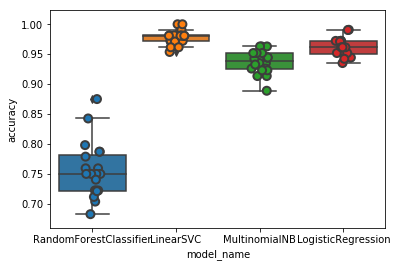

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

CV = 20

cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
        
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [36]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.976941
LogisticRegression        0.960452
MultinomialNB             0.936859
RandomForestClassifier    0.755662
Name: accuracy, dtype: float64

#### It appears that SVM is by far the best model for this task. Now, to tune the hyper-parameters.

2020-10-06 07:25:16,135 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.MaxNLocator object at 0x1a5e83f828>
2020-10-06 07:25:16,136 - matplotlib.colorbar - DEBUG - Using auto colorbar locator on colorbar
2020-10-06 07:25:16,136 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.MaxNLocator object at 0x1a5e83f828>
2020-10-06 07:25:16,137 - matplotlib.colorbar - DEBUG - Setting pcolormesh
2020-10-06 07:25:16,143 - matplotlib.axes._base - DEBUG - update_title_pos
2020-10-06 07:25:16,162 - matplotlib.axes._base - DEBUG - update_title_pos
2020-10-06 07:25:16,188 - matplotlib.axes._base - DEBUG - update_title_pos
2020-10-06 07:25:16,206 - matplotlib.axes._base - DEBUG - update_title_pos
2020-10-06 07:25:16,248 - matplotlib.axes._base - DEBUG - update_title_pos
2020-10-06 07:25:16,256 - matplotlib.axes._base - DEBUG - update_title_pos
2020-10-06 07:25:16,283 - matplotlib.axes._base - DEBUG - update_title_pos
2020-10-06 07:25:16,294 - matplotlib.axes._base - DEBUG - update

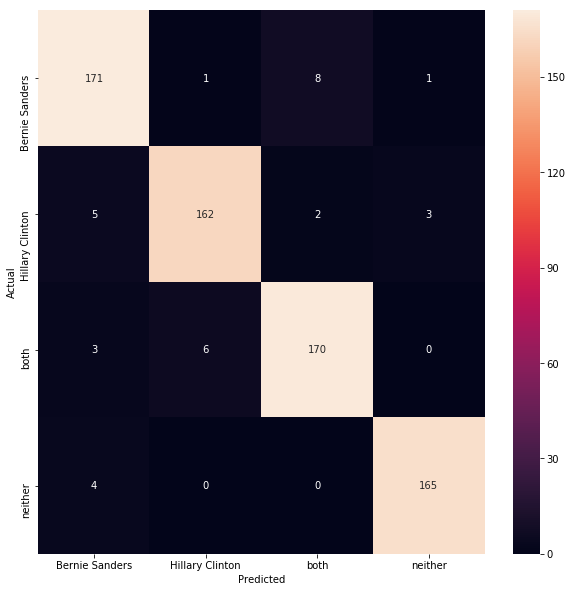

In [37]:
from sklearn.svm import SVC

# new model that incorporates probabilities. this might help decide which label to choose when 
# filtering-derived and ML-derived classifications are different.
model = SVC(kernel='linear', probability=True, random_state=0)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, nh_upsampled_df.index, test_size=0.33, random_state=0)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_nh_df.addressee.values, yticklabels=category_id_nh_df.addressee.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

The 'get_params()' method on the classifier object tells us which hyper-parameters were selected for this model. This allows us to tune the parameters using k-fold cross-validation. This is implemented using the 'GridSearchCV' method, using different tuning parameters defined in 'param_grid' 

In [39]:
model.get_params()

{'C': 1.0,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto_deprecated',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': True,
 'random_state': 0,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [40]:
param_grid = {'C': [1, 10, 50, 100, 200, 500, 1000, 10000], 'max_iter' : [1000, 10000, 100000]}

In [41]:
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(cv=10,estimator=model, param_grid=param_grid)
clf.fit(features, labels)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=0,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1, 10, 50, 100, 200, 500, 1000, 10000], 'max_iter': [1000, 10000, 100000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

### The most accurate/predictive model is chosen using the 'best_estimator' attribute on the cross-validation object.

In [42]:
final_model = clf.best_estimator_

final_model.fit(X_train, y_train)
final_model_preds = final_model.predict(X_test)

In [43]:
from sklearn import metrics
print(metrics.classification_report(y_test, final_model_preds, target_names=nh_df['addressee'].unique()))

                 precision    recall  f1-score   support

 Bernie Sanders       0.96      0.95      0.95       181
Hillary Clinton       0.97      0.97      0.97       172
           both       0.95      0.95      0.95       179
        neither       0.98      0.98      0.98       169

      micro avg       0.96      0.96      0.96       701
      macro avg       0.96      0.96      0.96       701
   weighted avg       0.96      0.96      0.96       701



## Now to apply the model on previously unseen data!

The previously unseen data is the 'nh_unlabelled_df' data frame. It needs to be slightly transformed first, including removal of columns that aren't relevant for this task. Also, the 'addressee' variable is transformed from the 'bernie_mention' and 'hillary_mention' variables, as these are dummies themselves, and not a 4-level categorical variable like the one we are looking to predict. The 'bernie_mention' and 'hillary_mention' variables come from the tweet text filtering approach taken in M_03.R.

In [65]:
col = ['id_str', 'text', 'bernie_mention', 'hillary_mention']
nh_unlabelled_df = nh_unlabelled_df[col]

In [66]:
nh_unlabelled_df['addressee'] = 'neither'
nh_unlabelled_df.loc[(nh_unlabelled_df.bernie_mention=='True') & (nh_unlabelled_df.hillary_mention=='True'), 'addressee'] = 'both'
nh_unlabelled_df.loc[(nh_unlabelled_df.bernie_mention=='True') & (nh_unlabelled_df.hillary_mention=='False'), 'addressee'] = 'Bernie Sanders'
nh_unlabelled_df.loc[(nh_unlabelled_df.bernie_mention=='False') & (nh_unlabelled_df.hillary_mention=='True'), 'addressee'] = 'Hillary Clinton'
nh_unlabelled_df = nh_unlabelled_df[pd.notnull(nh_unlabelled_df['text'])]

In [67]:
# what does the naive mention classification say about distribution of mentions by candidate?
# let' see how it compares to the classified values.
nh_unlabelled_df.addressee.value_counts()

Bernie Sanders     8967
Hillary Clinton    5810
both               3305
Name: addressee, dtype: int64

In [68]:
features_unseen = tfidf.transform(nh_unlabelled_df.text)
features_unseen.shape

(18082, 1935)

In [69]:
# make prediction on new data

preds_unseen_data = final_model.predict(features_unseen)
probs_unseen_data = final_model.predict_proba(features_unseen)

In [70]:
class_probabilites_df = pd.DataFrame(data=probs_unseen_data)
class_probabilites_df.columns = ['class_0', 'class_1', 'class_2', 'class_3']
class_probabilites_df = class_probabilites_df.round(decimals=3)

In [72]:
nh_unlabelled_df['preds_addressee'] = preds_unseen_data 
nh_unlabelled_df = pd.concat([nh_unlabelled_df, class_probabilites_df], axis=1)

In [73]:
nh_unlabelled_df

,id_str,text,bernie_mention,hillary_mention,addressee,preds_addressee,class_0,class_1,class_2,class_3
0,693269454881447936,@NHDems @iowademocrats @scdp #nhpolitics #iaca...,False,True,Hillary Clinton,1,0.000,0.996,0.004,0.000
1,692950898134368256,@NHDems @SCdems #nhpolitics #iapolitics #iacau...,True,True,both,2,0.005,0.023,0.972,0.000
2,692953880255152129,@NHDems @SCdems #nhpolitics #iapolitics #iacau...,True,True,both,2,0.005,0.023,0.972,0.000
3,693064737748340737,The bros who love Bernie Sanders have become a...,True,True,both,0,0.825,0.109,0.044,0.022
4,693261130333057024,RT @ABCLiz: Bill Clinton on what Hillary Clint...,False,True,Hillary Clinton,1,0.000,1.000,0.000,0.000
5,693036457217429504,RT @JazzShaw: Wow. Morning Joe crew actually d...,False,True,Hillary Clinton,1,0.003,0.964,0.017,0.016
6,693244905079095296,RT @cnnbrk: State Department says it won't rel...,False,True,Hillary Clinton,1,0.000,0.995,0.005,0.000
7,692998848143347713,@HillaryClinton,False,True,Hillary Clinton,1,0.000,0.999,0.001,0.000
8,693002209722830849,RT @Bernie_Sanders_: Robert Reich: I’ve Known ...,True,True,both,0,0.809,0.014,0.175,0.003
9,692952350873538560,RT @GuerrillaDems: #HillaryClinton 's attack d...,False,True,Hillary Clinton,1,0.000,0.990,0.009,0.000


In [74]:
# writing out nh_unlabelled_df to a csv file
# UPDATE -- not writing out to csv because csv doesn't seem to be working probably
#nh_unlabelled_df.to_csv(DATA_OUT+'nh_addressee_classified.csv', index=False)

In [81]:
nh_unlabelled_df.to_json(DATA_OUT+'nh_addressee_classified.json', orient='records', lines=True)

In [79]:
len(nh_unlabelled_df)

18082

In [76]:
nh_unlabelled_df.preds_addressee.value_counts()

0    9339
1    6104
2    2510
3     129
Name: preds_addressee, dtype: int64

In [77]:
nh_unlabelled_df.addressee.value_counts()

Bernie Sanders     8967
Hillary Clinton    5810
both               3305
Name: addressee, dtype: int64